# Time Series Data

Working with time series data is very common for data scientists.  How is this variable changing over time? Can we forecast future values of this variable?

Python and Pandas, of course, have lots of ways to deal with date and time based data.  In this notebook, we'll explore a few of those that might occur in a healthcare setting.

## 1. Python Dates and Times

We've talked about using the [datetime](https://docs.python.org/3/library/datetime.html) library and [Pandas datetime](https://pandas.pydata.org/docs/user_guide/timeseries.html) support to work date and time data.  In this example, we're going to use those features and the `meetings.csv` file to understand how to use those features to align, summarize, and forecast some timeseries data.

In step 1, let's load the data and convert the "startTime" field into a datetime data type.

In [1]:
import pandas as pd

# Load the meetings data
meetings = pd.read_csv('https://hds5210-data.s3.amazonaws.com/meetings.csv')

# But notice that the startTime field is not automatically read as a datetime
# It's just a generic "object"
meetings.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   meeting_uuid                          1188 non-null   object 
 1   meetingTitle                          1169 non-null   object 
 2   meetingId                             1188 non-null   int64  
 3   userName                              1188 non-null   object 
 4   user_id                               1188 non-null   int64  
 5   user_tags                             0 non-null      float64
 6   endTime                               1188 non-null   object 
 7   startTime                             1188 non-null   object 
 8   email                                 1188 non-null   object 
 9   participantSeconds                    1188 non-null   int64  
 10  joinDate                              1188 non-null   object 
 11  joinWeek         

In [2]:
# Let's examine the format to make sure we know how to convert it
meetings['startTime'].head()

# It's %Y-%m-%d %H:%M:%S -- see [strftime](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior)

0    2020-03-31 21:00:22
1    2020-03-31 20:58:41
2    2020-03-31 20:57:51
3    2020-03-31 20:34:43
4    2020-03-31 20:30:02
Name: startTime, dtype: object

In [3]:
# So, we'll create a new column called `start_ts` that is a datetime data type
meetings['start_ts'] = pd.to_datetime(meetings['startTime'])

# And check the data type
meetings['start_ts'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1188 entries, 0 to 1187
Series name: start_ts
Non-Null Count  Dtype         
--------------  -----         
1188 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 9.4 KB


<Axes: >

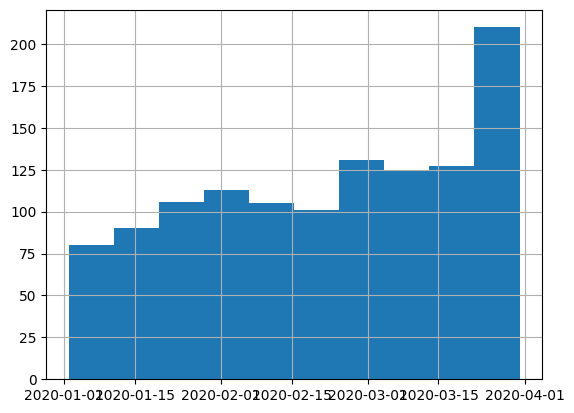

In [4]:
meetings['start_ts'].dt.date.hist()

## 2. Timezones

Many systems store timestamps using UTC (Universal Coordinated Time), but it doesn't make sense to do analysis this way if what we're really interested in is when are people meeting in their LOCAL timezone.  So, let's adjust the timestamps from UTC to local times based on where each user is located.



In [5]:
import pytz

# I never remember the timezone name for India...
pytz.country_timezones['IN']

['Asia/Kolkata']

In [6]:
timezones = {
    'eric.keeney':                     'US/Central',
    'paul.boal':                       'US/Central',
    'jeff.hatfield.amitechsolutions':  'US/Central',
    'paul.smith.amitechsolutions':     'US/Central',
    'tejus.maduskar':                  'US/Eastern',
    'amit.bhagat':                     'US/Central',
    'Drew.Marco':                      'US/Central',
    'michael.demos':                   'US/Central',
    'jennifer.patton.amitechs':        'US/Central',
    'melissa.menne':                   'US/Central',
    'jessica.sikora':                  'US/Central',
    'eric.rodman':                     'US/Central',
    'shawn.reilly.amitechsolutions':   'US/Eastern',
    'sandip.shaw':                     'US/Central',
    'raghavender.tuniki':              'Asia/Kolkata',
    'pete.cornwell':                   'US/Eastern',
    'chris.rogers.amitechsolutions':   'US/Eastern',
    'angie.warren':                    'US/Central',
    'andrea.bryant.amitechsolutions':  'US/Central',
    'matt.allsup':                     'US/Central',
    'santhosh.kanala':                 'US/Central',
    'matt.brown.amitechsolutions':     'US/Mountain',
    'vishal.dev':                      'US/Central'
}

In [7]:
# This adds the timezone information to the datetime field
# By default datetime objects don't have any timezone information
meetings['start_ts_utc'] = meetings['start_ts'].dt.tz_localize('UTC')

In [8]:
# Then we convert from UTC to a different timezone
# And remove the timezone information so we can pretend everything is in the local timezone
for userName, tz in timezones.items():
    filter = meetings['userName'] == userName
    meetings.loc[filter, 'start_ts_local'] = meetings.loc[filter, 'start_ts_utc'].dt.tz_convert(tz).dt.tz_localize(None, ambiguous='infer')

# .dt.tz_convert(tz)    -- Shifts the timezone, but not the actual time of the event
# .dt.tz_localize(None) -- Removes the timezone (i.e. sets the timezone information to None)


What we're doing here is "normalizing" the datetime so we can answer questions like "Do people usually have meetings at 8:00 AM in their local timezone"?

Here's an example:

```
userName  timezone   UTC                    Local
--------- ---------- ---------------------- --------------------
tejus     US/Eastern  2020-03-31 21:00:22   2020-03-31 15:00:22
paul      US/Central  2020-03-31 20:00:41   2020-03-31 15:00:41
```

Both of these meetings took place at 3:00 PM in their local time.

In [9]:
meetings[['start_ts_utc','start_ts_local']].head()

,start_ts_utc,start_ts_local
0,2020-03-31 21:00:22+00:00,2020-03-31 17:00:22
1,2020-03-31 20:58:41+00:00,2020-03-31 15:58:41
2,2020-03-31 20:57:51+00:00,2020-03-31 15:57:51
3,2020-03-31 20:34:43+00:00,2020-03-31 15:34:43
4,2020-03-31 20:30:02+00:00,2020-03-31 15:30:02


In [10]:
# Flag each meeting with if it is after noon
meetings['afterNoon'] = meetings['start_ts_local'].dt.hour >= 12

In [11]:
meetings['afterNoon'].value_counts()

False    616
True     572
Name: afterNoon, dtype: int64

In [12]:
# Count by day of how many meetings are in the afternoon
afternoon_mtg_count = meetings.pivot_table(index=meetings['start_ts_local'].dt.date, columns='afterNoon', values='start_ts_local', aggfunc='count')
afternoon_mtg_count.columns = afternoon_mtg_count.columns.map({
    False: 'beforeNoon',
    True: 'afterNoon'
})

afternoon_mtg_count.index = pd.to_datetime(afternoon_mtg_count.index)
afternoon_mtg_count = afternoon_mtg_count.asfreq('d')




<Axes: xlabel='start_ts_local'>

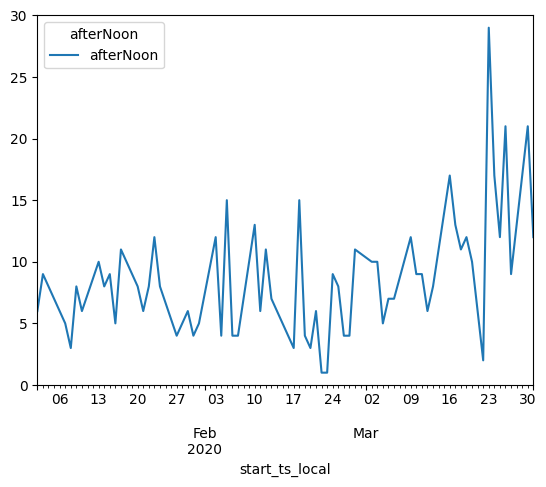

In [20]:
# Notice that we don't have data for every single day in that time period
# So, it's necessary to fill in the NaN with some kind of value
# We'll just use linear interpolation to fill in the NaN

afternoon_mtg_count.interpolate(method='linear', inplace=True)
afternoon_mtg_count[['afterNoon']].plot(ylim=(0,30))


## 3. Rolling Windows

It's often useful in timeseries analysis to "average over time" using a rolling window.  For example, we might assume that every week is sort of the same as the last in meeting planning.  However, weekends won't usuallly have weekends.  So, a 7-day rolling average might be a useful way to smooth out spikes in meeting count.

<Axes: xlabel='start_ts_local'>

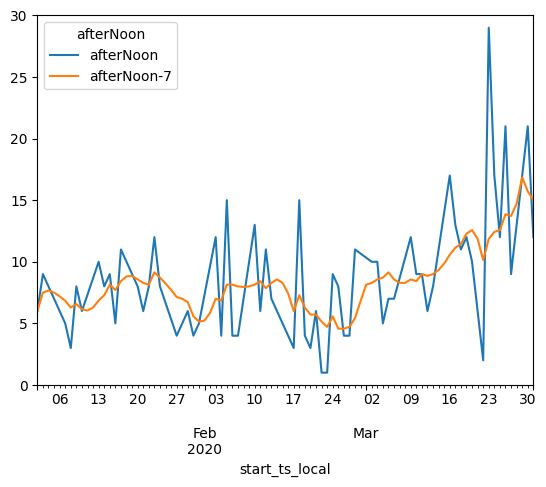

In [21]:
# Create a rolling mean
# Set min_periods to 1 so that we fill in the whole space including the first few days

afternoon_mtg_count['afterNoon-7'] = afternoon_mtg_count['afterNoon'].rolling(7, min_periods=1).mean()
afternoon_mtg_count[['afterNoon', 'afterNoon-7']].plot(ylim=(0,30))

## 4. Forecasting

But what we really want to do is build a forecast model to try to understand how many meetings we're going to have in future days and weeks.  One method for forecasting time series is called [Autoregressive Integrated Moving Average or ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html).  I won't go into figuring out parameters for the ARIMA module in this demo.

In [22]:
afternoon_mtg_count

afterNoon,beforeNoon,afterNoon,afterNoon-7
start_ts_local,,,
2020-01-02,6.000000,6.0,6.000000
2020-01-03,4.000000,9.0,7.500000
2020-01-04,4.333333,8.0,7.666667
2020-01-05,4.666667,7.0,7.500000
2020-01-06,5.000000,6.0,7.200000
...,...,...,...
2020-03-27,9.000000,9.0,13.714286
2020-03-28,10.000000,13.0,14.714286
2020-03-29,11.000000,17.0,16.857143


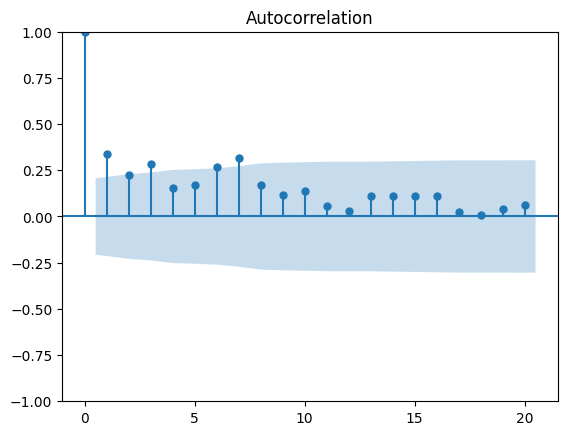

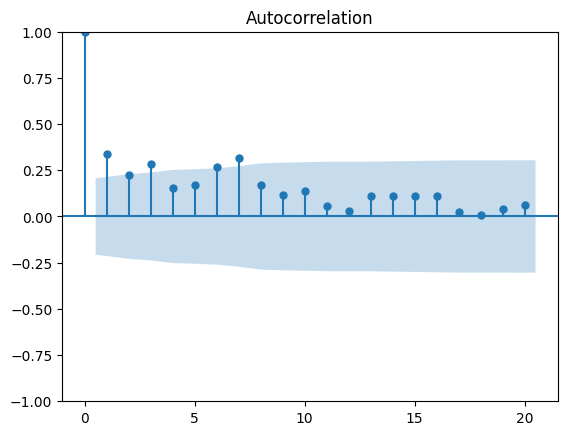

In [25]:
# The 
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(afternoon_mtg_count['afterNoon'])

In [73]:
# Now, we can build an ARIMA model
# Figuring out the right valus for "order" is outside the scope of this discussion
# See https://towardsdatascience.com/find-the-order-of-arima-models-b4d99d474e7a for some ideas
# Or https://people.duke.edu/~rnau/411arim.htm#:~:text=A%20nonseasonal%20ARIMA%20model%20is,errors%20in%20the%20prediction%20equation

from statsmodels.tsa.arima.model import ARIMA

# I chose (0,2,2) for "linear exponential smoothing" based on some trial and error
# given my business knowledge of the meetings going on
arima_model = ARIMA(afternoon_mtg_count['afterNoon-7'], order=(0,2,2))
model = arima_model.fit()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:            afterNoon-7   No. Observations:                   90
Model:                 ARIMA(0, 2, 2)   Log Likelihood                 -95.899
Date:                Tue, 05 Dec 2023   AIC                            197.799
Time:                        12:54:02   BIC                            205.231
Sample:                    01-02-2020   HQIC                           200.793
                         - 03-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8989      0.087    -10.363      0.000      -1.069      -0.729
ma.L2         -0.0887      0.085     -1.045      0.296      -0.255       0.078
sigma2         0.4975      0.073      6.823      0.0

### Let's look at the predicted values

You can see they're very close to the moving average over 7 days

<Axes: xlabel='start_ts_local'>

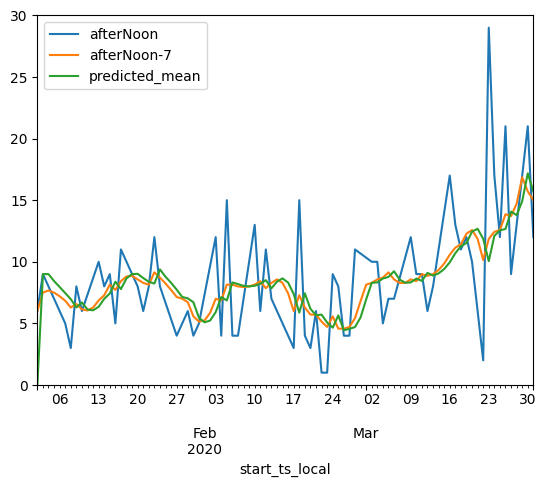

In [77]:
pd.concat([
    afternoon_mtg_count['afterNoon'],
    afternoon_mtg_count['afterNoon-7'],
    model.predict()
], axis=1).plot(ylim=(0,30))

<Axes: >

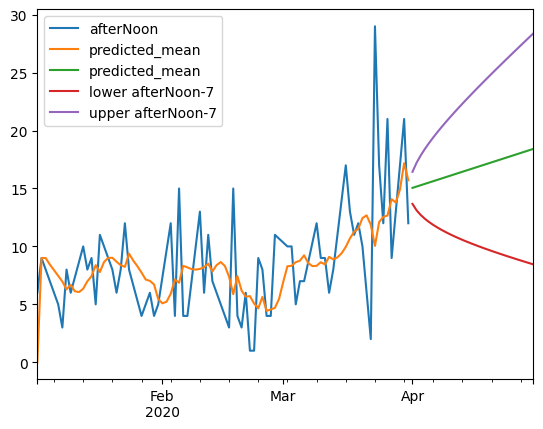

In [75]:
# And we can use that model to forecast the next 30 days
forecast = model.get_forecast(steps=30)

# Then plot everything together on one line chart
pd.concat([
    afternoon_mtg_count['afterNoon'],
    model.predict(),
    forecast.predicted_mean,
    forecast.conf_int(alpha=0.05)  # 95% confidence interval
],axis=1).plot()